In [2]:
import os
import sys
project_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_dir not in sys.path:
    sys.path.append(project_dir)
utils_path = project_dir.join("utils")
sys.path.append(utils_path)
from util.utils import upload_file_to_s3, download_file_from_s3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
nome_arquivo = 'dados_unificados.csv'
url_s3 = f'https://tcc-gp06-analytics-prod.s3.amazonaws.com/consumed/{nome_arquivo}'
download_file_from_s3(url_s3, f'../../data/{nome_arquivo}')

Arquivo baixado com sucesso e salvo como ../../data/dados_unificados.csv!


In [4]:
dados = f'../../data/{nome_arquivo}'
df = pd.read_csv(dados)

### Pré-processamento

#### Valores Nulos

In [5]:
df.isna().sum()

empresa                               0
data                                  0
vl_abertura                           0
vl_minimo                             0
vl_maximo                             0
vl_fechamento                         0
pc_variacao_dia                       0
qt_negociacoes                        0
vl_dividendo                          0
pc_desdobramento                      0
vl_dolar                              0
pc_inflacao_mes                       0
pc_taxa_selic                         0
lpa                               11354
pl                                11354
pvp                               11354
p_ebit                            11354
p_ebitda                          11354
ebitda                            11354
roe                               11354
roic                              11354
dy                                11354
payout                            11354
vl_receita_liquida                10610
vl_resultado_bruto                10610


#### identificando volumetria de nulos por empresa

In [6]:
valores_nulos = df[df['lpa'].isnull()].groupby('empresa').size().reset_index(name='valores_nulos')
total_registros = df.groupby('empresa').size().reset_index(name='total_registros')
valores_nulos = pd.merge(valores_nulos, total_registros, on='empresa', how='right').fillna(0)

print(valores_nulos)
print("-------------------------------------------")
print("     Soma:        ", valores_nulos['valores_nulos'].sum(), "         ", valores_nulos['total_registros'].sum())

   empresa  valores_nulos  total_registros
0     AESB            0.0              792
1     ALUP            0.0             2754
2     AURE            0.0              544
3     CMIG          250.0             6068
4     COCE            0.0             6068
5     CPFE         1006.0             6068
6     CPLE          500.0             6068
7     EGIE            0.0             5528
8     ELET         2249.0             6068
9     ENEV          258.0             4077
10    ENGI            0.0             3611
11    EQTL            0.0             4004
12    NEOE            0.0             1223
13    SRNA            0.0              606
14    TAEE         1023.0             4098
15    TRPL         6068.0             6068
-------------------------------------------
     Soma:         11354.0           63645


#### Removendo registros que possuem nulos

In [7]:
df = df[df['lpa'].notnull()]
df = df[df['pc_margem_liquida'].notnull()]

### Selecionando empresas a partir de indicadores
Filtro realizado da seguinte forma:
1. Empresas que possuem os indicadores ROE e ROIC acima da média das empresas de energia
2. Ordenando essas empresas por maior valor de mercado (por dezena de bilhão de R$)
3. Ordenando pela quantidade de dados disponíveis
4. Seleciando as 5 primeiras que aparecerem, as quais estão citadas abaixo:

| Ticker | Empresa        | Valor Mercado | Qtd. Dados |
| ------ | ---------------| ------------- | ---------- |
| CPFE   | CPFL ENERGIA™  | R$ 40B        | 5062       |
| EGIE   | Engie™         | R$ 36B        | 5528       |
| EQTL   | Equatorial™    | R$ 35B        | 4004       |
| CMIG   | Cemig™         | R$ 23B        | 5818       |
| NEOE   | Neoenergia™    | R$ 24B        | 1223       |


In [8]:
grouped_df = df.groupby('empresa').agg(
    qt_negociacoes=('qt_negociacoes', 'mean'),
    volume_dados=('empresa', 'size')
).reset_index()

ordered_df = grouped_df.sort_values(by=['qt_negociacoes', 'volume_dados'], ascending=[False, False])

media_volume = ordered_df['volume_dados'].mean() # media de dados para análise
media_negociacoes = ordered_df['qt_negociacoes'].mean() # média de negociações

In [9]:
df_medias = df.groupby('empresa').agg(
    qt_negociacoes=('qt_negociacoes', 'mean'),
    volume_dados=('empresa', 'size'),
    roe=('roe', 'mean'),
    roic=('roic', 'mean'),
    lpa=('lpa', 'mean'),
    pl=('pl', 'mean'),
    pvp=('pvp', 'mean'),
    pc_margem_bruta=('pc_margem_bruta', 'mean'),
    pc_margem_liquida=('pc_margem_liquida', 'mean'),
    ebitda=('ebitda', 'mean'),
    p_ebit=('p_ebit', 'mean'),
    p_ebitda=('p_ebitda', 'mean'),
    dy=('dy', 'mean'),
    payout=('payout', 'mean')
).reset_index()

criteria = (
    # (df_medias['volume_dados'] > media_volume) &
    # (df_medias['qt_negociacoes'] > media_negociacoes) &
    (df_medias['roe'] > df_medias['roe'].mean()) &
    (df_medias['roic'] > df_medias['roic'].mean()) 
    # (df_medias['lpa'] > df_medias['lpa'].mean()) &
    # & (df_medias['pl'] > df_medias['pl'].mean())
    # (df_medias['pvp'] >= 1)
    # (df_medias['pc_margem_bruta'] > df_medias['pc_margem_bruta'].mean()) &
    # (df_medias['pc_margem_liquida'] > df_medias['pc_margem_liquida'].mean()) &
    # (df_medias['ebitda'] > df_medias['ebitda'].mean()) &
    # (df_medias['p_ebit'] > 0) &
    # (df_medias['p_ebitda'] > 0) &
    # (df_medias['dy'] > df_medias['dy'].mean()) &
    # (df_medias['payout'] > 0)
)

df_filtrado = pd.DataFrame(df[df['empresa'].isin(df_medias[criteria].sort_values(by=['qt_negociacoes', 'volume_dados'], ascending=[False, False])['empresa'])]['empresa'].unique())
df_filtrado = df[df['empresa'].isin(df_filtrado[0])]
df_filtrado = df_filtrado.drop_duplicates(['empresa', 'vl_mercado_empresa'])[['empresa', 'vl_mercado_empresa']]
df_filtrado = df_filtrado.merge(df_medias[['empresa', 'volume_dados']], on='empresa', how='left')
df_filtrado
# df_medias

,empresa,vl_mercado_empresa,volume_dados
0,ALUP,8.987333e+09,2754
1,CMIG,2.285023e+10,5818
2,COCE,2.590236e+09,6068
3,CPFE,4.039803e+10,5062
4,EGIE,3.572133e+10,5528
5,EQTL,3.458531e+10,4004
6,NEOE,2.375896e+10,1223
7,TAEE,1.216081e+10,3075


In [10]:
df_filtrado['vl_mercado_empresa'] = round(df_filtrado['vl_mercado_empresa'] / 10_000_000_000,1)

In [11]:
df_filtrado = df_filtrado.sort_values(by=['vl_mercado_empresa', 'volume_dados'], ascending=[False, False])
df_filtrado = df_filtrado.iloc[0:5]
df_filtrado = df[df['empresa'].isin(df_filtrado['empresa'])]


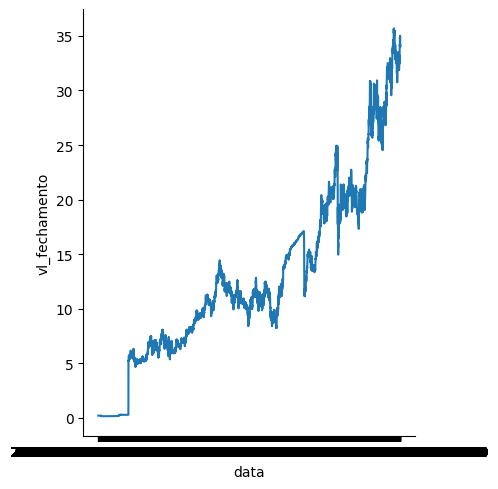

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# plt.figure(figsize=(14, 8))
# df_ordered = df.sort_values(by='data')

# # Agrupar por empresa e plotar cada um
# # for empresa in df_filtrado['empresa'].unique():
# #     print(empresa)
empresa_data = df_filtrado[df_filtrado['empresa'] == 'CPFE']
# plt.plot(empresa_data['vl_abertura'], label='EGIE')

# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.grid(True)
# plt.show()

sns.relplot(x="data", y="vl_fechamento", data=empresa_data, kind="line", 
            markers = False,
            dashes = False)
plt.show()

In [16]:
df_filtrado[df_filtrado['empresa'] == 'CPFE'].to_csv('../../data/dados_cpfe.csv')

In [21]:
df_filtrado[df_filtrado['empresa'] == 'EQTL'].to_csv('../../data/dados_eqtl.csv')
df_filtrado[df_filtrado['empresa'] == 'CMIG'].to_csv('../../data/dados_cmig.csv')
df_filtrado[df_filtrado['empresa'] == 'NEOE'].to_csv('../../data/dados_neoe.csv')
df_filtrado[df_filtrado['empresa'] == 'EGIE'].to_csv('../../data/dados_egie.csv')